In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")


In [3]:
USE_OWN_DATA = False

if USE_OWN_DATA:
    
    csv_path = "your_data.csv"               
    feature_cols = None                      
    df = pd.read_csv(csv_path)

    
    if feature_cols is None:
        feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        print("Auto-selected numeric columns:", feature_cols)

    X_df = df[feature_cols].dropna().copy()
else:
    
    iris = load_iris(as_frame=True)
    df = iris.frame.copy()              
    feature_cols = iris.feature_names   
    X_df = df[feature_cols].copy()

print("Shape:", X_df.shape)
X_df.head()


Shape: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

print("Scaled feature matrix shape:", X_scaled.shape)


Scaled feature matrix shape: (150, 4)


In [7]:
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_.sum()
print(f"PCA 2D retains ~{explained_var*100:.2f}% of variance")

PCA 2D retains ~95.81% of variance


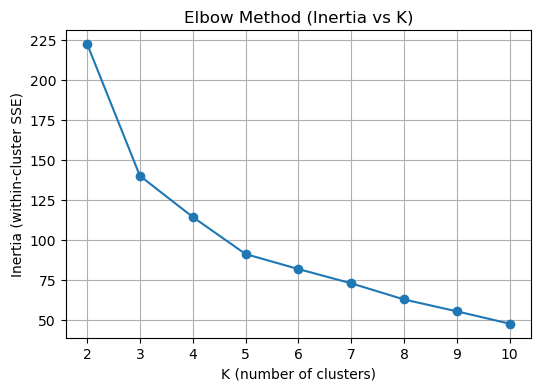

In [9]:
inertias = []
K_range = range(2, 11)  

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("K (number of clusters)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.grid(True)
plt.show()

K= 2  Silhouette Score = 0.5818
K= 3  Silhouette Score = 0.4599
K= 4  Silhouette Score = 0.3869
K= 5  Silhouette Score = 0.3459
K= 6  Silhouette Score = 0.3171
K= 7  Silhouette Score = 0.3202
K= 8  Silhouette Score = 0.3387
K= 9  Silhouette Score = 0.3424
K=10  Silhouette Score = 0.3518

Best K by Silhouette: 2


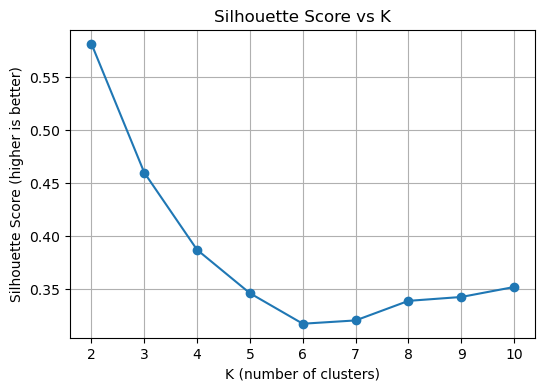

In [11]:
sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, labels)
    sil_scores.append(s)
    print(f"K={k:2d}  Silhouette Score = {s:.4f}")

best_k = K_range[int(np.argmax(sil_scores))]
print("\nBest K by Silhouette:", best_k)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("K (number of clusters)")
plt.ylabel("Silhouette Score (higher is better)")
plt.grid(True)
plt.show()




In [13]:
final_k = best_k  
kmeans = KMeans(n_clusters=final_k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

result_df = X_df.copy()
result_df["cluster"] = cluster_labels
result_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


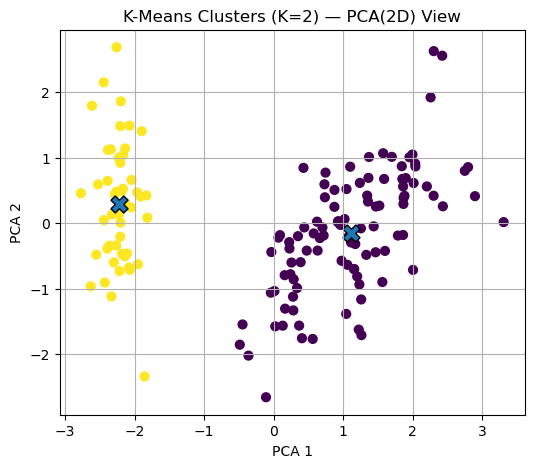

In [15]:
two_feature_mode = (X_df.shape[1] == 2)

plt.figure(figsize=(6,5))
if two_feature_mode:
    
    xname, yname = X_df.columns[:2]
    plt.scatter(X_df[xname], X_df[yname], c=cluster_labels, s=40)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title(f"K-Means Clusters (K={final_k}) — Original 2D Features")
else:
    
    plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=cluster_labels, s=40)
    
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=150, edgecolor='k')
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"K-Means Clusters (K={final_k}) — PCA(2D) View")

plt.grid(True)
plt.show()

In [17]:
sil = silhouette_score(X_scaled, cluster_labels)
print(f"Final Silhouette Score (K={final_k}): {sil:.4f}")

Final Silhouette Score (K=2): 0.5818


In [19]:
print("Cluster sizes:")
print(result_df["cluster"].value_counts().sort_index(), "\n")

print("Feature means by cluster (on original scale):")
display(result_df.groupby("cluster").mean(numeric_only=True))

Cluster sizes:
cluster
0    100
1     50
Name: count, dtype: int64 

Feature means by cluster (on original scale):


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
cluster,,,,
0,6.262,2.872,4.906,1.676
1,5.006,3.428,1.462,0.246


In [21]:
out_path = "kmeans_clusters_output.csv"
result_df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

Saved: kmeans_clusters_output.csv
